In [2]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |################################| 2.0 MB 8.7 MB/s            
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ivgmeepr
  Running command git clone --filter=blob:none -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ivgmeepr
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266208 sha256=3ec6dacc50e0d7c9c7f25a9b847acada4008e7575ea151c07f23cba31a7ea83f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dpmbx1jm/wheels/25/c1/63/8bee2969883497d2785c9bdbe4e89cae5efc59521553d528bf
Successfully built pycocotools


In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2
import glob
import pandas as pd

In [2]:
DATASET = 'data'

files = glob.glob('data/**/*.txt', recursive = True) #find all *.txt files

target_txt = "dataset_not_orig.txt"

In [3]:
train_df = pd.read_csv(target_txt, sep=',', header=None, names=['img_path', 'x0', 'y0', 'x1', 'y1', 'label'])
train_df.head()

,img_path,x0,y0,x1,y1,label
0,19-12-09_1652_624622812/000_03_04.png,463.0,204.0,560.0,241.0,2
1,19-12-09_1652_624622812/000_03_04.png,64.0,470.0,210.0,540.0,2
2,19-12-09_1652_624622812/000_03_04.png,267.0,464.0,332.0,535.0,1
3,19-12-09_1652_624622812/000_03_04.png,577.0,184.0,610.0,294.0,1
4,19-12-09_1652_624622812/000_03_04.png,346.0,268.0,421.0,366.0,1


In [14]:
class FallenPeople(torch.utils.data.Dataset):
      def __init__(self, dataframe, transforms=None):
        super().__init__()
        self.image_ids = dataframe['img_path'].unique()
        self.df = dataframe
        self.transforms = transforms

      def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df['img_path'] == image_id]

        image = cv2.imread(f'{DATASET}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x0', 'y0', 'x1', 'y1']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['label'].values
        labels = torch.as_tensor(labels, dtype = torch.int64)
        image_id = torch.tensor([idx])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_path'] = torch.tensor([idx])
        target['area'] = area
        target["image_id"] = image_id
        target['iscrowd'] = iscrowd


        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

      def __len__(self) -> int:
        return len(self.image_ids)

In [15]:
dataset = FallenPeople(train_df)
dataset[0]

(array([[[0.3137255 , 0.31764707, 0.29411766],
         [0.35686275, 0.32156864, 0.3019608 ],
         [0.34509805, 0.3137255 , 0.29803923],
         ...,
         [0.11764706, 0.27058825, 0.22745098],
         [0.12941177, 0.23137255, 0.20784314],
         [0.21176471, 0.2       , 0.1882353 ]],
 
        [[0.3137255 , 0.28627452, 0.27058825],
         [0.32941177, 0.26666668, 0.25490198],
         [0.32941177, 0.29411766, 0.27450982],
         ...,
         [0.14509805, 0.25882354, 0.21960784],
         [0.18039216, 0.2627451 , 0.21568628],
         [0.33333334, 0.25490198, 0.20784314]],
 
        [[0.3254902 , 0.2627451 , 0.25490198],
         [0.30980393, 0.24705882, 0.24313726],
         [0.2901961 , 0.26666668, 0.25882354],
         ...,
         [0.1764706 , 0.31764707, 0.2627451 ],
         [0.17254902, 0.36078432, 0.2901961 ],
         [0.15686275, 0.40392157, 0.31764707]],
 
        ...,
 
        [[0.13333334, 0.14509805, 0.1764706 ],
         [0.13333334, 0.14901961, 0.18039

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [17]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = FallenPeople(train_df, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/usr/local/lib/python3.6/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [18]:
# get len of dataset
images_ids = train_df['img_path'].unique()
# use our dataset and defined transformations
dataset = FallenPeople(train_df, get_transform(train=True))
dataset_test = FallenPeople(train_df, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
split_len = round(len(images_ids)*0.8)

dataset = torch.utils.data.Subset(dataset, indices[:split_len])
dataset_test = torch.utils.data.Subset(dataset_test, indices[split_len:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)

In [19]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [20]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/309]  eta: 0:02:45  lr: 0.000021  loss: 1.8973 (1.8973)  loss_classifier: 1.1484 (1.1484)  loss_box_reg: 0.6750 (0.6750)  loss_objectness: 0.0607 (0.0607)  loss_rpn_box_reg: 0.0131 (0.0131)  time: 0.5361  data: 0.0825  max mem: 0
Epoch: [0]  [ 10/309]  eta: 0:02:33  lr: 0.000183  loss: 1.9041 (3.0536)  loss_classifier: 1.0478 (0.9599)  loss_box_reg: 0.5535 (0.5912)  loss_objectness: 0.5572 (1.1786)  loss_rpn_box_reg: 0.0509 (0.3238)  time: 0.5132  data: 0.0634  max mem: 0
Epoch: [0]  [ 20/309]  eta: 0:02:27  lr: 0.000346  loss: 1.6488 (2.2930)  loss_classifier: 0.6453 (0.7211)  loss_box_reg: 0.5535 (0.5703)  loss_objectness: 0.3017 (0.7796)  loss_rpn_box_reg: 0.0324 (0.2220)  time: 0.5090  data: 0.0614  max mem: 0
Epoch: [0]  [ 30/309]  eta: 0:02:22  lr: 0.000508  loss: 1.2881 (1.9951)  loss_classifier: 0.4325 (0.6273)  loss_box_reg: 0.5831 (0.5760)  loss_objectness: 0.1179 (0.6164)  loss_rpn_box_reg: 0.0213 (0.1754)  time: 0.5077  data: 0.0629  max mem: 0
Epoch: [0]  

Test:  [153/154]  eta: 0:00:00  model_time: 0.0966 (0.0966)  evaluator_time: 0.0060 (0.0090)  time: 0.1364  data: 0.0305  max mem: 0
Test: Total time: 0:00:23 (0.1553 s / it)
Averaged stats: model_time: 0.0966 (0.0966)  evaluator_time: 0.0060 (0.0090)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.9

Epoch: [1]  [280/309]  eta: 0:00:15  lr: 0.005000  loss: 0.4471 (0.6281)  loss_classifier: 0.1396 (0.1390)  loss_box_reg: 0.1934 (0.2130)  loss_objectness: 0.0730 (0.1718)  loss_rpn_box_reg: 0.0133 (0.1044)  time: 0.5299  data: 0.0601  max mem: 0
Epoch: [1]  [290/309]  eta: 0:00:10  lr: 0.005000  loss: 0.5023 (0.6299)  loss_classifier: 0.1401 (0.1395)  loss_box_reg: 0.1906 (0.2129)  loss_objectness: 0.0898 (0.1716)  loss_rpn_box_reg: 0.0197 (0.1059)  time: 0.5293  data: 0.0599  max mem: 0
Epoch: [1]  [300/309]  eta: 0:00:04  lr: 0.005000  loss: 0.5450 (0.6297)  loss_classifier: 0.1617 (0.1405)  loss_box_reg: 0.2004 (0.2135)  loss_objectness: 0.1094 (0.1700)  loss_rpn_box_reg: 0.0148 (0.1057)  time: 0.5290  data: 0.0606  max mem: 0
Epoch: [1]  [308/309]  eta: 0:00:00  lr: 0.005000  loss: 0.5450 (0.6298)  loss_classifier: 0.1241 (0.1408)  loss_box_reg: 0.1802 (0.2125)  loss_objectness: 0.0992 (0.1712)  loss_rpn_box_reg: 0.0141 (0.1052)  time: 0.5157  data: 0.0577  max mem: 0
Epoch: [1] T

Epoch: [2]  [230/309]  eta: 0:00:41  lr: 0.005000  loss: 0.3463 (0.5313)  loss_classifier: 0.0999 (0.1158)  loss_box_reg: 0.1711 (0.1837)  loss_objectness: 0.0454 (0.1348)  loss_rpn_box_reg: 0.0226 (0.0969)  time: 0.5318  data: 0.0639  max mem: 0
Epoch: [2]  [240/309]  eta: 0:00:36  lr: 0.005000  loss: 0.4978 (0.5376)  loss_classifier: 0.1052 (0.1165)  loss_box_reg: 0.1877 (0.1847)  loss_objectness: 0.0675 (0.1391)  loss_rpn_box_reg: 0.0227 (0.0973)  time: 0.5300  data: 0.0616  max mem: 0
Epoch: [2]  [250/309]  eta: 0:00:31  lr: 0.005000  loss: 0.5713 (0.5383)  loss_classifier: 0.1202 (0.1171)  loss_box_reg: 0.2192 (0.1861)  loss_objectness: 0.0756 (0.1386)  loss_rpn_box_reg: 0.0208 (0.0964)  time: 0.5303  data: 0.0616  max mem: 0
Epoch: [2]  [260/309]  eta: 0:00:25  lr: 0.005000  loss: 0.4532 (0.5324)  loss_classifier: 0.1119 (0.1169)  loss_box_reg: 0.1901 (0.1859)  loss_objectness: 0.0694 (0.1358)  loss_rpn_box_reg: 0.0146 (0.0937)  time: 0.5315  data: 0.0636  max mem: 0
Epoch: [2]  

Epoch: [3]  [180/309]  eta: 0:01:08  lr: 0.000500  loss: 0.3088 (0.4323)  loss_classifier: 0.0877 (0.1018)  loss_box_reg: 0.1420 (0.1595)  loss_objectness: 0.0322 (0.0951)  loss_rpn_box_reg: 0.0105 (0.0758)  time: 0.5321  data: 0.0639  max mem: 0
Epoch: [3]  [190/309]  eta: 0:01:02  lr: 0.000500  loss: 0.3502 (0.4277)  loss_classifier: 0.0829 (0.1013)  loss_box_reg: 0.1850 (0.1604)  loss_objectness: 0.0354 (0.0924)  loss_rpn_box_reg: 0.0112 (0.0736)  time: 0.5310  data: 0.0620  max mem: 0
Epoch: [3]  [200/309]  eta: 0:00:57  lr: 0.000500  loss: 0.3998 (0.4344)  loss_classifier: 0.0888 (0.1030)  loss_box_reg: 0.1850 (0.1614)  loss_objectness: 0.0412 (0.0954)  loss_rpn_box_reg: 0.0136 (0.0746)  time: 0.5302  data: 0.0610  max mem: 0
Epoch: [3]  [210/309]  eta: 0:00:52  lr: 0.000500  loss: 0.4375 (0.4337)  loss_classifier: 0.1033 (0.1026)  loss_box_reg: 0.1857 (0.1614)  loss_objectness: 0.0462 (0.0960)  loss_rpn_box_reg: 0.0270 (0.0737)  time: 0.5312  data: 0.0626  max mem: 0
Epoch: [3]  

Epoch: [4]  [130/309]  eta: 0:01:34  lr: 0.000500  loss: 0.3689 (0.4003)  loss_classifier: 0.0774 (0.0950)  loss_box_reg: 0.1094 (0.1527)  loss_objectness: 0.0369 (0.0884)  loss_rpn_box_reg: 0.0095 (0.0642)  time: 0.5295  data: 0.0613  max mem: 0
Epoch: [4]  [140/309]  eta: 0:01:29  lr: 0.000500  loss: 0.3093 (0.3935)  loss_classifier: 0.0813 (0.0947)  loss_box_reg: 0.1508 (0.1531)  loss_objectness: 0.0278 (0.0850)  loss_rpn_box_reg: 0.0079 (0.0607)  time: 0.5333  data: 0.0640  max mem: 0
Epoch: [4]  [150/309]  eta: 0:01:24  lr: 0.000500  loss: 0.2608 (0.3930)  loss_classifier: 0.0764 (0.0942)  loss_box_reg: 0.1428 (0.1534)  loss_objectness: 0.0325 (0.0846)  loss_rpn_box_reg: 0.0072 (0.0609)  time: 0.5325  data: 0.0640  max mem: 0
Epoch: [4]  [160/309]  eta: 0:01:18  lr: 0.000500  loss: 0.2592 (0.3863)  loss_classifier: 0.0696 (0.0928)  loss_box_reg: 0.1369 (0.1516)  loss_objectness: 0.0270 (0.0819)  loss_rpn_box_reg: 0.0070 (0.0601)  time: 0.5328  data: 0.0645  max mem: 0
Epoch: [4]  

Epoch: [5]  [ 80/309]  eta: 0:02:01  lr: 0.000500  loss: 0.2868 (0.3390)  loss_classifier: 0.0866 (0.0888)  loss_box_reg: 0.1187 (0.1358)  loss_objectness: 0.0270 (0.0664)  loss_rpn_box_reg: 0.0100 (0.0480)  time: 0.5328  data: 0.0649  max mem: 0
Epoch: [5]  [ 90/309]  eta: 0:01:55  lr: 0.000500  loss: 0.3100 (0.3519)  loss_classifier: 0.0880 (0.0893)  loss_box_reg: 0.1411 (0.1374)  loss_objectness: 0.0272 (0.0720)  loss_rpn_box_reg: 0.0191 (0.0532)  time: 0.5330  data: 0.0647  max mem: 0
Epoch: [5]  [100/309]  eta: 0:01:50  lr: 0.000500  loss: 0.3389 (0.3497)  loss_classifier: 0.0737 (0.0880)  loss_box_reg: 0.1628 (0.1393)  loss_objectness: 0.0364 (0.0697)  loss_rpn_box_reg: 0.0207 (0.0527)  time: 0.5331  data: 0.0645  max mem: 0
Epoch: [5]  [110/309]  eta: 0:01:45  lr: 0.000500  loss: 0.3271 (0.3522)  loss_classifier: 0.0683 (0.0888)  loss_box_reg: 0.1628 (0.1423)  loss_objectness: 0.0306 (0.0701)  loss_rpn_box_reg: 0.0126 (0.0511)  time: 0.5290  data: 0.0609  max mem: 0
Epoch: [5]  

Epoch: [6]  [ 30/309]  eta: 0:02:27  lr: 0.000050  loss: 0.2955 (0.3560)  loss_classifier: 0.0829 (0.0885)  loss_box_reg: 0.1490 (0.1379)  loss_objectness: 0.0361 (0.0840)  loss_rpn_box_reg: 0.0136 (0.0456)  time: 0.5326  data: 0.0647  max mem: 0
Epoch: [6]  [ 40/309]  eta: 0:02:22  lr: 0.000050  loss: 0.2561 (0.3469)  loss_classifier: 0.0775 (0.0862)  loss_box_reg: 0.1313 (0.1386)  loss_objectness: 0.0313 (0.0782)  loss_rpn_box_reg: 0.0108 (0.0440)  time: 0.5308  data: 0.0640  max mem: 0
Epoch: [6]  [ 50/309]  eta: 0:02:17  lr: 0.000050  loss: 0.2287 (0.3379)  loss_classifier: 0.0537 (0.0826)  loss_box_reg: 0.1078 (0.1330)  loss_objectness: 0.0286 (0.0766)  loss_rpn_box_reg: 0.0085 (0.0457)  time: 0.5297  data: 0.0629  max mem: 0
Epoch: [6]  [ 60/309]  eta: 0:02:11  lr: 0.000050  loss: 0.2287 (0.3313)  loss_classifier: 0.0637 (0.0809)  loss_box_reg: 0.0919 (0.1289)  loss_objectness: 0.0452 (0.0755)  loss_rpn_box_reg: 0.0084 (0.0460)  time: 0.5294  data: 0.0626  max mem: 0
Epoch: [6]  

Epoch: [7]  [  0/309]  eta: 0:02:40  lr: 0.000050  loss: 0.1007 (0.1007)  loss_classifier: 0.0279 (0.0279)  loss_box_reg: 0.0646 (0.0646)  loss_objectness: 0.0061 (0.0061)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.5183  data: 0.0712  max mem: 0
Epoch: [7]  [ 10/309]  eta: 0:02:38  lr: 0.000050  loss: 0.2778 (0.2688)  loss_classifier: 0.0690 (0.0733)  loss_box_reg: 0.1453 (0.1456)  loss_objectness: 0.0311 (0.0345)  loss_rpn_box_reg: 0.0071 (0.0155)  time: 0.5291  data: 0.0668  max mem: 0
Epoch: [7]  [ 20/309]  eta: 0:02:32  lr: 0.000050  loss: 0.2778 (0.2663)  loss_classifier: 0.0734 (0.0770)  loss_box_reg: 0.1286 (0.1349)  loss_objectness: 0.0320 (0.0385)  loss_rpn_box_reg: 0.0109 (0.0159)  time: 0.5296  data: 0.0654  max mem: 0
Epoch: [7]  [ 30/309]  eta: 0:02:27  lr: 0.000050  loss: 0.2455 (0.3013)  loss_classifier: 0.0683 (0.0715)  loss_box_reg: 0.1261 (0.1330)  loss_objectness: 0.0320 (0.0489)  loss_rpn_box_reg: 0.0085 (0.0479)  time: 0.5303  data: 0.0634  max mem: 0
Epoch: [7]  

Test:  [153/154]  eta: 0:00:00  model_time: 0.0958 (0.0964)  evaluator_time: 0.0033 (0.0048)  time: 0.1326  data: 0.0307  max mem: 0
Test: Total time: 0:00:20 (0.1335 s / it)
Averaged stats: model_time: 0.0958 (0.0964)  evaluator_time: 0.0033 (0.0048)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.9

Epoch: [8]  [280/309]  eta: 0:00:15  lr: 0.000050  loss: 0.2621 (0.3427)  loss_classifier: 0.0751 (0.0823)  loss_box_reg: 0.1342 (0.1392)  loss_objectness: 0.0241 (0.0602)  loss_rpn_box_reg: 0.0093 (0.0610)  time: 0.5294  data: 0.0614  max mem: 0
Epoch: [8]  [290/309]  eta: 0:00:10  lr: 0.000050  loss: 0.2610 (0.3404)  loss_classifier: 0.0817 (0.0823)  loss_box_reg: 0.1505 (0.1398)  loss_objectness: 0.0183 (0.0591)  loss_rpn_box_reg: 0.0079 (0.0593)  time: 0.5312  data: 0.0622  max mem: 0
Epoch: [8]  [300/309]  eta: 0:00:04  lr: 0.000050  loss: 0.2326 (0.3380)  loss_classifier: 0.0557 (0.0816)  loss_box_reg: 0.1228 (0.1390)  loss_objectness: 0.0191 (0.0585)  loss_rpn_box_reg: 0.0065 (0.0589)  time: 0.5315  data: 0.0630  max mem: 0
Epoch: [8]  [308/309]  eta: 0:00:00  lr: 0.000050  loss: 0.2263 (0.3391)  loss_classifier: 0.0593 (0.0816)  loss_box_reg: 0.1140 (0.1391)  loss_objectness: 0.0315 (0.0596)  loss_rpn_box_reg: 0.0094 (0.0588)  time: 0.5213  data: 0.0634  max mem: 0
Epoch: [8] T

Epoch: [9]  [230/309]  eta: 0:00:41  lr: 0.000005  loss: 0.2678 (0.3264)  loss_classifier: 0.0583 (0.0798)  loss_box_reg: 0.1337 (0.1359)  loss_objectness: 0.0369 (0.0601)  loss_rpn_box_reg: 0.0120 (0.0506)  time: 0.5289  data: 0.0613  max mem: 0
Epoch: [9]  [240/309]  eta: 0:00:36  lr: 0.000005  loss: 0.2927 (0.3272)  loss_classifier: 0.0749 (0.0795)  loss_box_reg: 0.1399 (0.1364)  loss_objectness: 0.0297 (0.0600)  loss_rpn_box_reg: 0.0110 (0.0512)  time: 0.5298  data: 0.0621  max mem: 0
Epoch: [9]  [250/309]  eta: 0:00:31  lr: 0.000005  loss: 0.2509 (0.3242)  loss_classifier: 0.0749 (0.0793)  loss_box_reg: 0.1275 (0.1356)  loss_objectness: 0.0254 (0.0589)  loss_rpn_box_reg: 0.0101 (0.0504)  time: 0.5302  data: 0.0623  max mem: 0
Epoch: [9]  [260/309]  eta: 0:00:25  lr: 0.000005  loss: 0.2395 (0.3215)  loss_classifier: 0.0724 (0.0790)  loss_box_reg: 0.1297 (0.1355)  loss_objectness: 0.0188 (0.0579)  loss_rpn_box_reg: 0.0068 (0.0490)  time: 0.5314  data: 0.0637  max mem: 0
Epoch: [9]  

In [36]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [37]:
prediction

[{'boxes': tensor([[672.3694, 118.4521, 699.2968, 182.6059],
          [736.1420, 291.8103, 763.7131, 373.4866],
          [522.9703, 293.5381, 554.2029, 377.7282],
          [766.1786, 152.5105, 791.9767, 202.5639],
          [620.7883,  89.9523, 637.2161, 126.5394],
          [868.9386, 180.7396, 898.3055, 261.6020],
          [435.5126, 231.1579, 501.4847, 266.8464],
          [620.3971, 520.5838, 719.2421, 619.4428],
          [773.5930, 395.7233, 835.0411, 455.5688],
          [567.0151, 298.1811, 620.4180, 345.5850],
          [565.3735, 297.5234, 621.1359, 348.6693],
          [772.5885, 395.5182, 834.5093, 457.2183],
          [621.9430, 519.4167, 721.1677, 620.3547],
          [768.8204, 706.6639, 786.8296, 718.8077],
          [735.7419, 167.2297, 766.8140, 195.1597],
          [733.8787, 167.2166, 769.7072, 194.5838],
          [846.4056, 124.5270, 866.6409, 160.8695],
          [730.8129, 162.0206, 740.6529, 183.5807]], device='cuda:1'),
  'labels': tensor([1, 1, 1, 1, 1, 1

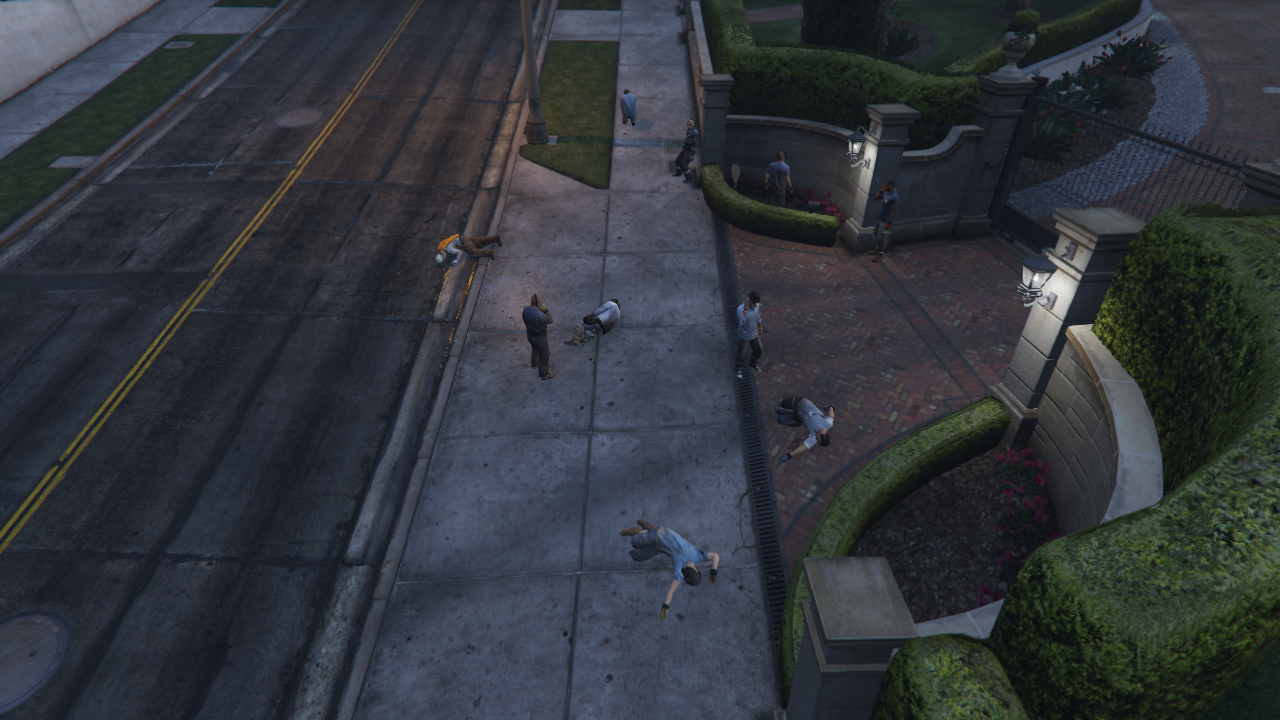

In [91]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
im

In [105]:
from PIL import ImageDraw, ImageShow, ImageFont

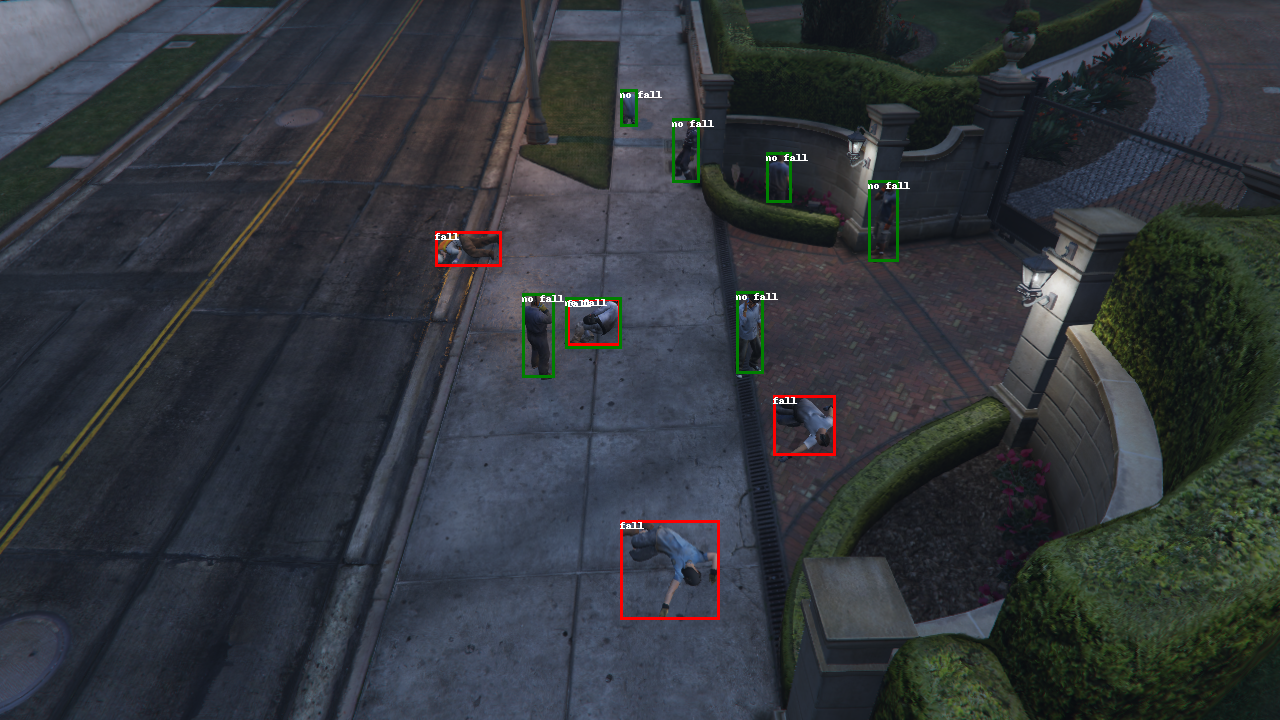

1

In [108]:
boxes = prediction[0]['boxes'].tolist()
labels = prediction[0]['labels'].tolist()
scores = prediction[0]['scores'].tolist()
l = len(scores)
# for b,l,s in boxes,labels,scores:
#     if s > 0.5:
#         if l == 1:
#             color = 'green'
#             text = 'no fall'
#         elif l == 2:
#             color = 'red'
#             text = 'fall'
#         x0,y0,x1,y1 = b
        
#         draw = ImageDraw.Draw(im)
#         draw.rectangle(((x0, y0),(x1,y1)), outline="green", width=3)

for i in range(l):
    if scores[i] > 0.5:
        if labels[i] == 1:
            color = 'green'
            text = 'no fall'
        elif labels[i] == 2:
            color = 'red'
            text = 'fall'
        x0,y0,x1,y1 = boxes[i]
        
        draw = ImageDraw.Draw(im)
        draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
        draw.text((x0, y0), text)
        
ImageShow.show(im)

In [103]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fallen_people.pth')